In [78]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf
import os
import scipy.optimize as optimize
import scipy.stats as stats

In [ ]:
''' RED PAPER 02/05/23  '''

In [5]:
''' 1 '''
################################'Generate X and Y'##############################
################################ Xt ~ N(0,1)
################################ Yt = α + βYt-1 + γXt + εt + θεt-1
def generate_data(T, alpha_y, beta_y, gamma, theta, sigma_y, mu, seed=None):
    np.random.seed(seed)
    df = pd.DataFrame(index=range(T), columns=['x', 'y', 'epsilon_y'])
    x = np.random.normal(0, 1, T)
    y1 = np.random.normal(mu, sigma_y)
    epsilon_y = sigma_y*np.random.randn(T)
    df.iloc[0,:] = [x[0], y1, epsilon_y[0]]
    
    for i in range(0, T-1):
        df.iloc[i+1,0] = x[i+1] 
        # Xt ~ N(0,1)
        df.iloc[i+1,1] = alpha_y + beta_y * df.iloc[i,1] + gamma * df.iloc[i+1,0] + epsilon_y[i+1] + theta * epsilon_y[i] # generate Y(t) recursively
        # Yt = α + βYt-1 + γXt + εt + θεt-1
        df.iloc[i+1,2] = epsilon_y[i+1]
    
    return df

In [7]:
df = generate_data(1000, 0.2, 0.5, 0.3, 0.9, 1, 0, seed=42)
print(df)

            x         y epsilon_y
0    0.496714  1.399355  0.924634
1   -0.138264  1.749999   0.05963
2    0.647689  0.676037 -0.646937
3     1.52303  1.110908  0.698223
4   -0.234153  1.707094  0.393485
..        ...       ...       ...
995   -0.2811  2.353144 -0.026521
996  1.797687  1.010134 -0.881875
997  0.640843 -0.059434 -0.163067
998 -0.571179 -0.892734 -0.744903
999  0.572583 -1.420183 -0.675178

[1000 rows x 3 columns]


In [8]:
''' OLS GLS estimation 1 repetiotion'''
def ols_gls_estimation(df):
    # convert data to float64 data type
    df = df.astype('float64')
    # extract data
    x = df['x'].values
    y = df['y'].values
    epsilon_y = df['epsilon_y'].values
    T = len(y)

    # OLS estimation of the parameters
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    epsilon_lag = np.roll(epsilon_y, 1)
    epsilon_lag[0] = 0
    X = np.column_stack((np.ones_like(x), y_lag, x))
    beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
    
    ε = y - X @ beta_hat
    ε = ε.reshape((-1, 1))
    ε_lag = np.roll(ε, 1)
    ε_lag[0] = 0
    ε_lag = ε_lag.reshape((-1, 1))
    theta_hat = np.linalg.inv(ε.T @ ε_lag) @ ε_lag.T @ ε
    
    acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=50, alpha=0.05)
    sigma2 = np.var(ε) * (1 - acf_resid[1])
    sigma2_array = np.full(T, sigma2)
    rho = acf_resid[1] / (1 - acf_resid[1])
    S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
    beta_gls = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y
    theta_gls = np.linalg.inv(ε.T @ np.linalg.inv(S) @ ε_lag) @ ε_lag.T @ np.linalg.inv(S) @ ε
    print("OLS parameter estimates:")
    print("alpha_hat = {:.4f}".format(beta_hat[0]))
    print("beta_hat = {:.4f}".format(beta_hat[1]))
    print("gamma_hat = {:.4f}".format(beta_hat[2]))
    print("theta_hat = {:.4f}".format(theta_hat[0, 0])) 
    print("GLS parameter estimates:")
    print("alpha_gls = {:.4f}".format(beta_gls[0]))
    print("beta_gls = {:.4f}".format(beta_gls[1]))
    print("gamma_gls = {:.4f}".format(beta_gls[2]))
    print("theta_gls = {:.4f}".format(theta_gls[0, 0]))

In [9]:
ols_gls_estimation(df)

OLS parameter estimates:
alpha_hat = 0.1665
beta_hat = 0.7437
gamma_hat = 0.2938
theta_hat = 1.0000
GLS parameter estimates:
alpha_gls = 0.2713
beta_gls = 0.5879
gamma_gls = 0.3118
theta_gls = 1.0000


In [ ]:
''' 1 rep --> gls way better
OLS parameter estimates:
alpha_hat = 0.0987
beta_hat = 0.7426
gamma_hat = 0.3107
theta_hat = 1.0000
GLS parameter estimates:
alpha_gls = 0.2053
beta_gls = 0.5110
gamma_gls = 0.3058
theta_gls = 1.0000
'''

In [153]:
''' Iterations M'''
def ols_gls_estimation2(df, M):
    df = df.astype('float64') # convert data to float64 data type
    x = df['x'].values     # extract data
    y = df['y'].values
    epsilon_y = df['epsilon_y'].values
    T = len(y)
    
    beta_ols = np.empty((M, 3)) # initialize arrays to store results
    beta_gls = np.empty((M, 3))
    theta_ols = np.empty(M)
    theta_gls = np.empty(M)
    y_sim = []
    M = len(y_sim)

    for i in range(M):
        sigma2 = 1
        #epsilon = np.random.normal(loc=0, scale=np.sqrt(sigma2), size=T)
        epsilon = np.random.normal(loc=0, scale=np.sqrt(sigma2), size=(T)) # generate new epsilon values for each iteration
        epsilon_lag = np.roll(epsilon, 1)
        epsilon_lag[0] = 0
        epsilon = epsilon.reshape((-1, 1))
        epsilon_lag = epsilon_lag.reshape((-1, 1))
        y_lag = np.roll(y, 1)
        y_lag[0] = 0   

        X = np.column_stack((np.ones_like(x), y_lag, x)) # OLS estimation of the parameters
        beta_ols[i] = np.linalg.inv(X.T @ X) @ X.T @ y
        y_sim[i] = X @ beta_ols[i] + epsilon[i] # generate new y values for each iteration
        
        ε = y_sim[i] - X @ beta_ols[i]
        ε = ε.reshape((-1, 1))
        ε_lag = np.roll(ε, 1)
        ε_lag[0] = 0
        ε_lag = ε_lag.reshape((-1, 1))
        theta_ols[i] = np.linalg.inv(ε.T @ ε_lag) @ ε_lag.T @ ε

        acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=10, alpha=0.05)
        sigma2 = np.var(ε) * (1 - acf_resid[1])
        sigma2_array = np.full(T, sigma2)
        rho = acf_resid[1] / (1 - acf_resid[1])
        S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
        beta_gls[i] = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y_sim[i]
        theta_gls[i] = np.linalg.inv(ε.T @ np.linalg.inv(S) @ ε_lag) @ ε_lag.T @ np.linalg.inv(S) @ ε
    
    print("OLS parameter estimates:") # print results
    print("alpha_hat = {:.4f}".format(np.mean(beta_ols[:, 0])))
    print("beta_hat = {:.4f}".format(np.mean(beta_ols[:, 1])))
    print("gamma_hat = {:.4f}".format(np.mean(beta_ols[:, 2])))
    print("theta_hat = {:.4f}".format(np.mean(theta_ols))) 
    print("GLS parameter estimates:")
    print("alpha_gls = {:.4f}".format(np.mean(beta_gls[:, 0])))
    print("beta_gls = {:.4f}".format(np.mean(beta_gls[:, 1])))
    print("gamma_gls = {:.4f}".format(np.mean(beta_gls[:, 2])))
    print("theta_gls = {:.4f}".format(np.mean(theta_gls))) 


In [176]:
M = 10
ols_gls_estimation2(df, M)

OLS parameter estimates:
alpha_hat = 0.0000
beta_hat = 0.0000
gamma_hat = 0.0000
theta_hat = 0.0000
GLS parameter estimates:
alpha_gls = 0.0133
beta_gls = 0.0717
gamma_gls = 0.0335
theta_gls = 0.0000


In [180]:
M = 10000
ols_gls_estimation2(df, M)

OLS parameter estimates:
alpha_hat = 0.0000
beta_hat = 0.0000
gamma_hat = 0.0000
theta_hat = 0.3425
GLS parameter estimates:
alpha_gls = 0.0000
beta_gls = 0.0000
gamma_gls = 0.0000
theta_gls = -0.0784


In [181]:
def ols_gls_estimation3(df, M):
    beta_hat_list = []
    beta_gls_list = []
    theta_hat_list = []
    theta_gls_list = []
    
    for i in range(M):
        df = df.astype('float64') # convert data to float64 data type
        x = df['x'].values # extract data
        y = df['y'].values
        epsilon_y = df['epsilon_y'].values
        T = len(y)

        y_lag = np.roll(y, 1)
        y_lag[0] = 0
        epsilon_lag = np.roll(epsilon_y, 1)
        epsilon_lag[0] = 0
        X = np.column_stack((np.ones_like(x), y_lag, x)) # OLS estimation of the parameters
        beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y

        ε = y - X @ beta_hat
        ε = ε.reshape((-1, 1))
        ε_lag = np.roll(ε, 1)
        ε_lag[0] = 0
        ε_lag = ε_lag.reshape((-1, 1))
        theta_hat = np.linalg.inv(ε.T @ ε_lag) @ ε_lag.T @ ε

        acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=10, alpha=0.05)
        sigma2 = np.var(ε) * (1 - acf_resid[1])
        sigma2_array = np.full(T, sigma2)
        rho = acf_resid[1] / (1 - acf_resid[1])
        S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
        beta_gls = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y
        theta_gls = np.linalg.inv(ε.T @ np.linalg.inv(S) @ ε_lag) @ ε_lag.T @ np.linalg.inv(S) @ ε

        beta_hat_list.append(beta_hat)
        beta_gls_list.append(beta_gls)
        theta_hat_list.append(theta_hat[0, 0])
        theta_gls_list.append(theta_gls[0, 0])
    
    print("OLS parameter estimates:")
    print("alpha_hat = {:.4f}".format(np.mean([b[0] for b in beta_hat_list])))
    print("beta_hat = {:.4f}".format(np.mean([b[1] for b in beta_hat_list])))
    print("gamma_hat = {:.4f}".format(np.mean([b[2] for b in beta_hat_list])))
    print("theta_hat = {:.4f}".format(np.mean(theta_hat_list))) 
    print("GLS parameter estimates:")
    print("alpha_gls = {:.4f}".format(np.mean([b[0] for b in beta_gls_list])))
    print("beta_gls = {:.4f}".format(np.mean([b[1] for b in beta_gls_list])))
    print("gamma_gls = {:.4f}".format(np.mean([b[2] for b in beta_gls_list])))
    print("theta_gls = {:.4f}".format(np.mean(theta_gls_list))) 


In [182]:
M = 10
ols_gls_estimation3(df, M)

OLS parameter estimates:
alpha_hat = 0.1327
beta_hat = 0.7170
gamma_hat = 0.3350
theta_hat = 1.0000
GLS parameter estimates:
alpha_gls = 0.1601
beta_gls = 0.6295
gamma_gls = -0.2430
theta_gls = 1.0000


In [183]:
M = 100
ols_gls_estimation3(df, M)

OLS parameter estimates:
alpha_hat = 0.1327
beta_hat = 0.7170
gamma_hat = 0.3350
theta_hat = 1.0000
GLS parameter estimates:
alpha_gls = 0.1601
beta_gls = 0.6295
gamma_gls = -0.2430
theta_gls = 1.0000


In [79]:
M = 100
ols_gls_estimation3(df, M)

OLS parameter estimates:
alpha_hat = 0.1327
beta_hat = 0.7170
gamma_hat = 0.3350
theta_hat = 1.0000
GLS parameter estimates:
alpha_gls = 0.1601
beta_gls = 0.6295
gamma_gls = -0.2430
theta_gls = 1.0000


In [168]:
''' Iterations M'''
def ols_gls_estimation4(df, M):
    for i in range(M):
        # convert data to float64 data type
        df = df.astype('float64')
        # extract data
        x = df['x'].values
        y = df['y'].values
        epsilon_y = df['epsilon_y'].values
        T = len(y)
        
        # initialize arrays to store results
        beta_ols = np.empty((M, 3))
        beta_gls = np.empty((M, 3))
        theta_ols = np.empty(M)
        theta_gls = np.empty(M)
        y_sim = np.empty((M, T))
        # generate new epsilon values for each iteration
        sigma2 = 1
        epsilon = np.random.normal(loc=0, scale=np.sqrt(sigma2), size=T)
        epsilon_lag = np.roll(epsilon, 1)
        epsilon_lag[0] = 0
        #epsilon = epsilon.reshape((-1, 1))
        #epsilon_lag = epsilon_lag.reshape((-1, 1))
        y_lag = np.roll(y, 1)
        y_lag[0] = 0
        #y_lag = y_lag.reshape((-1, 1))
        # OLS estimation of the parameters
        X = np.column_stack((np.ones_like(x), y_lag, x))
        beta_ols_curr = np.linalg.inv(X.T @ X) @ X.T @ y
        beta_ols[i] = beta_ols_curr
        # generate new y values for each iteration
        epsilon = epsilon.reshape((-1, 1))
        y_sim[i] = beta_ols_curr[0] + beta_ols_curr[1] * y_lag + beta_ols_curr[2] * x + epsilon

#np.tile(epsilon, (1, 3))
        ε = y_sim[i] - X @ beta_ols_curr
        ε = ε.reshape((-1, 1))
        ε_lag = np.roll(ε, 1)
        ε_lag[0] = 0
        ε_lag = ε_lag.reshape((-1, 1))
        theta_ols[i] = np.linalg.inv(ε.T @ ε_lag) @ ε_lag.T @ ε

        acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=10, alpha=0.05)
        sigma2 = np.var(ε) * (1 - acf_resid[1])
        sigma2_array = np.full(T, sigma2)
        rho = acf_resid[1] / (1 - acf_resid[1])
        S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
        beta_gls_curr = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y_sim[i]
        beta_gls[i] = beta_gls_curr
        theta_gls[i] = np.linalg.inv(ε.T @ np.linalg.inv(S) @ ε_lag) @ ε_lag.T @ np.linalg.inv(S) @ ε

    # print results
    print("OLS parameter estimates:")
    print("alpha_hat = {:.4f}".format(np.mean(beta_ols[:, 0])))
    print("beta_hat = {:.4f}".format(np.mean(beta_ols[:, 1])))
    print("gamma_hat = {:.4f}".format(np.mean(beta_ols[:, 2])))
    print("theta_hat = {:.4f}".format(np.mean(theta_ols))) 
    print("GLS parameter estimates:")
    print("alpha_gls = {:.4f}".format(np.mean(beta_gls[:, 0])))
    print("beta_gls = {:.4f}".format(np.mean(beta_gls[:, 1])))
    print("gamma_gls = {:.4f}".format(np.mean(beta_gls[:, 2])))
    print("theta_gls = {:.4f}".format(np.mean(theta_gls))) 


In [169]:
M = 10
ols_gls_estimation4(df, M)

ValueError: could not broadcast input array from shape (1000,1000) into shape (1000,)

In [10]:

################################ Quantile linear regression with package ################################
def fit_quantile(df):
    y = df['y'].values.astype(float)
    x = df['x'].values.astype(float)
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    
    X = np.column_stack((np.ones_like(x), y_lag, x))

    quant_reg_1 = sm.QuantReg(y, X).fit(q=0.1)
    quant_reg_5 = sm.QuantReg(y, X).fit(q=0.5)
    quant_reg_9 = sm.QuantReg(y, X).fit(q=0.9)

    # Plot the scatter data and the quantile regression lines
    fig, ax = plt.subplots()
    ax.scatter(x, y, alpha=0.5)

    # Generate x values for the regression lines
    x_vals = np.linspace(np.min(x), np.max(x), 100)

    # Plot the regression lines
    ax.plot(x_vals, quant_reg_1.params[0] + quant_reg_1.params[1]*0 + quant_reg_1.params[2]*x_vals, 'r', label='Quantile level: 0.1')
    ax.plot(x_vals, quant_reg_5.params[0] + quant_reg_5.params[1]*0 + quant_reg_5.params[2]*x_vals, 'g', label='Quantile level: 0.5')
    ax.plot(x_vals, quant_reg_9.params[0] + quant_reg_9.params[1]*0 + quant_reg_9.params[2]*x_vals, 'b', label='Quantile level: 0.9')

    # Add a legend and labels to the plot
    ax.legend()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Quantile regression at different quantile levels')

    plt.show()

################################ Autocorrelation of the residuals ##############################
    residuals_1 = quant_reg_1.resid # Calculate the residuals
    residuals_5 = quant_reg_5.resid # Calculate the residuals
    residuals_9 = quant_reg_9.resid # Calculate the residuals

    # Plot the autocorrelation function of the residuals for all three quantile regression models in one plot
    fig, ax = plt.subplots(3, 1, figsize=(8, 10))
    plot_acf(quant_reg_1.resid, ax=ax[0])
    ax[0].set_title('Autocorrelation of residuals (quantile level = 0.1)')
    plot_acf(quant_reg_5.resid, ax=ax[1])
    ax[1].set_title('Autocorrelation of residuals (quantile level = 0.5)')
    plot_acf(quant_reg_9.resid, ax=ax[2])
    ax[2].set_title('Autocorrelation of residuals (quantile level = 0.9)')
    plt.tight_layout()
    plt.show()

    return quant_reg_1.summary(), quant_reg_5.summary(), quant_reg_9.summary()

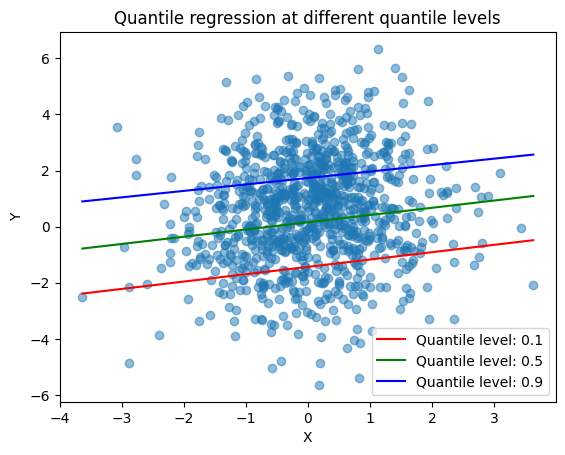

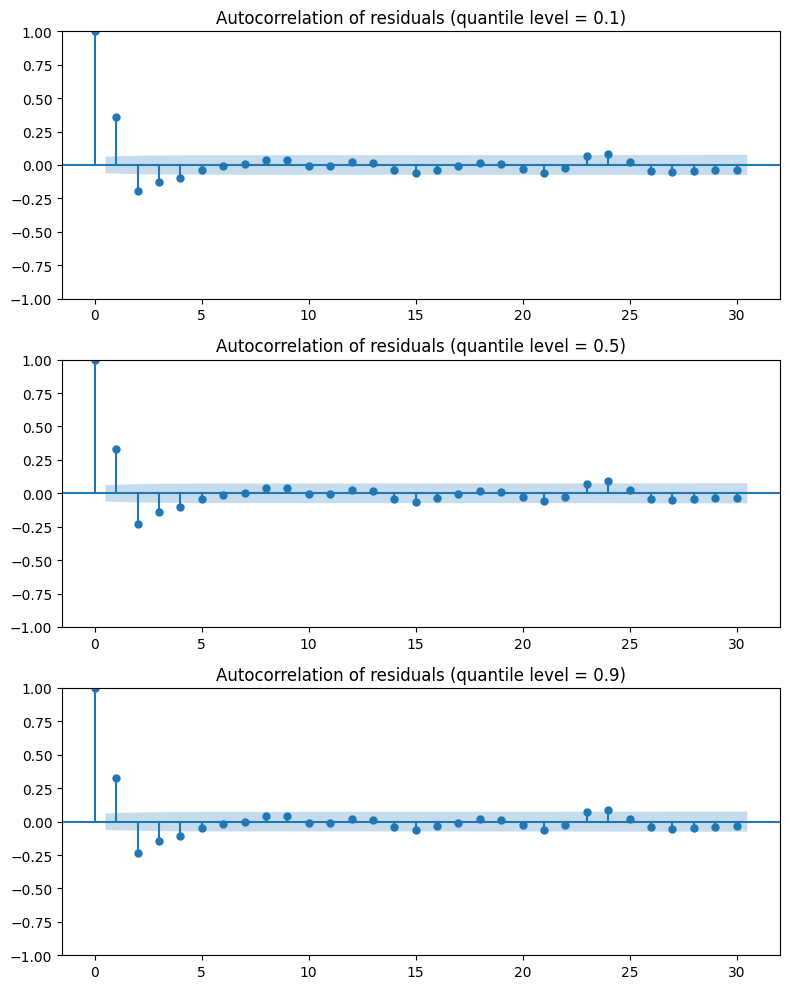

(<class 'statsmodels.iolib.summary.Summary'>
 """
                          QuantReg Regression Results                          
 Dep. Variable:                      y   Pseudo R-squared:               0.3595
 Model:                       QuantReg   Bandwidth:                      0.5250
 Method:                 Least Squares   Sparsity:                        6.722
 Date:                Sun, 07 May 2023   No. Observations:                 1000
 Time:                        11:33:43   Df Residuals:                      997
                                         Df Model:                            2
                  coef    std err          t      P>|t|      [0.025      0.975]
 ------------------------------------------------------------------------------
 const         -1.4333      0.067    -21.248      0.000      -1.566      -1.301
 x1             0.7211      0.035     20.385      0.000       0.652       0.791
 x2             0.2615      0.062      4.228      0.000       0.140   

In [310]:
fit_quantile(df)

In [11]:
''' 2.A OLS Liklihood            B method  results close to beta above'''

def OLS_loglikelihood(params, x, y):
    alpha, beta, gamma, theta, sigma = params
    T = len(y)
    ll = 0
    for t in range(1, T):
        mu = alpha + beta * y[t-1] + gamma * x[t] #X𝛽
        sigma2 = sigma**2 * (1 + theta**2)
        ll += -T/2 * np.log(2*np.pi) - T/2 * np.log(sigma2) - T/(2*sigma2) * np.sum((y[t]-mu)**2)
    return -ll

x = df['x'].values # Load data
y = df['y'].values

params0 = np.array([0.1, 0.1, 0.1, 0.1, 0.1]) # Initial parameter values

# Run optimization to find MLE
result = optimize.minimize(OLS_loglikelihood, params0, args=(x, y), method='L-BFGS-B', bounds=[(-np.inf, np.inf), (-1, 1), (-np.inf, np.inf), (-np.inf, np.inf), (0, np.inf)])

print('Estimated alpha:', result.x[0]) # Print estimated parameters
print('Estimated beta:', result.x[1])
print('Estimated gamma:', result.x[2])
print('Estimated theta:', result.x[3])
print('Estimated sigma:', result.x[4])


Estimated alpha: 0.16528272507481268
Estimated beta: 0.7438567142934158
Estimated gamma: 0.29325373665152304
Estimated theta: 0.07972997422575029
Estimated sigma: 1.2445370923378432


In [12]:
''' 2.B GLS Liklihood  with β_ols values       (exact same results as β_gls above)
'''
def GLS_logliklihood(df):
    df = df.astype('float64') # convert data to float64 data type
    x = df['x'].values # extract data
    y = df['y'].values
    epsilon_y = df['epsilon_y'].values
    T = len(y)

    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    epsilon_lag = np.roll(epsilon_y, 1)
    epsilon_lag[0] = 0
    X = np.column_stack((np.ones_like(x), y_lag, x))
    beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y  # OLS estimation of the parameters
    
    ε = y - X @ beta_hat
    ε = ε.reshape((-1, 1))
    ε_lag = np.roll(ε, 1)
    ε_lag[0] = 0
    ε_lag = ε_lag.reshape((-1, 1))
    theta_hat = np.linalg.inv(ε.T @ ε_lag) @ ε_lag.T @ ε
    
    acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=10, alpha=0.05)
    sigma2 = np.var(ε) * (1 - acf_resid[1])
    sigma2_array = np.full(T, sigma2)
    rho = acf_resid[1] / (1 - acf_resid[1])
    S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
    
    def neg_log_likelihood(beta_hat, X, y, S):
        T  = len(y)
        resid = y - X @ beta_hat
        return T/2 * np.log(np.linalg.det(S)) + T/2 * resid.T @ np.linalg.inv(S) @ resid
    beta_guess = np.zeros(X.shape[1]) # initial guess for beta
    res = optimize.minimize(neg_log_likelihood, beta_hat, args=(X, y, S)) # minimize the negative log-likelihood
    beta_gls = res.x # the estimated beta is in res.x

    print("GLS parameter estimates:")
    print("alpha_gls = {:.4f}".format(beta_gls[0]))
    print("beta_gls = {:.4f}".format(beta_gls[1]))
    print("gamma_gls = {:.4f}".format(beta_gls[2]))
    #print("theta_gls = {:.4f}".format(theta_gls[0, 0]))


In [13]:
GLS_logliklihood(df)

GLS parameter estimates:
alpha_gls = 0.2713
beta_gls = 0.5879
gamma_gls = 0.3118


In [15]:
''' 2.C GLS Liklihoood that takes OLS liklihood values'''
#def OLS_GLS_loglikelihood(d):


def OLS_loglikelihood(params, x, y):
    alpha, beta, gamma, theta, sigma = params
    T = len(y)
    ll = 0
    for t in range(1, T):
        mu = alpha + beta * y[t-1] + gamma * x[t] #X𝛽
        sigma2 = sigma**2 * (1 + theta**2)
        ll += -T/2 * np.log(2*np.pi) - T/2 * np.log(sigma2) - T/(2*sigma2) * np.sum((y[t]-mu)**2)
    return -ll

x = df['x'].values # Load data
y = df['y'].values

params0 = np.array([0.1, 0.1, 0.1, 0.1, 0.1]) # Initial parameter values

result = optimize.minimize(OLS_loglikelihood, params0, args=(x, y), method='L-BFGS-B', bounds=[(-np.inf, np.inf), (-1, 1), (-np.inf, np.inf), (-np.inf, np.inf), (0, np.inf)])

beta_hat = result.x[:3] # Store the first 3 estimated parameters
theta_hat = result.x[3]
sigma_hat = result.x[4] # Store the last estimated parameter as sigma

print('Estimated alpha:', beta_hat[0]) # Print estimated parameters
print('Estimated beta:', beta_hat[1])
print('Estimated gamma:', beta_hat[2])
print('Estimated theta:', theta_hat)
print('Estimated sigma:', sigma_hat)

df = df.astype('float64') # convert data to float64 data type

T = len(y)

y_lag = np.roll(y, 1)
y_lag[0] = 0
X = np.column_stack((np.ones_like(x), y_lag, x))

ε = y - X @ beta_hat # Calculate residuals using estimated parameters
    
ε = ε.reshape((-1, 1))
    
acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=10, alpha=0.05)
sigma2 = np.var(ε) * (1 - acf_resid[1])
sigma2_array = np.full(T, sigma2)
rho = acf_resid[1] / (1 - acf_resid[1])
S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
    
def neg_log_likelihood(beta_hat, X, y, S):
    T  = len(y)
    resid = y - X @ beta_hat
    return T/2 * np.log(np.linalg.det(S)) + T/2 * resid.T @ np.linalg.inv(S) @ resid
beta_guess = np.zeros(X.shape[1]) # initial guess for beta
res = optimize.minimize(neg_log_likelihood, beta_hat, args=(X, y, S)) # minimize the negative log-likelihood
beta_gls = res.x # the estimated beta is in res.x

print("GLS parameter estimates:")
print("alpha_gls = {:.4f}".format(beta_gls[0]))
print("beta_gls = {:.4f}".format(beta_gls[1]))
print("gamma_gls = {:.4f}".format(beta_gls[2]))
#print("theta_gls = {:.4f}".format(theta_gls[0, 0])) 
                                                            #''' ***************QUESTION************** '''


Estimated alpha: 0.16528272507481268
Estimated beta: 0.7438567142934158
Estimated gamma: 0.29325373665152304
Estimated theta: 0.07972997422575029
Estimated sigma: 1.2445370923378432
GLS parameter estimates:
alpha_gls = 0.2711
beta_gls = 0.5881
gamma_gls = 0.3118


In [16]:
''' 3.A logliklihood_asymmetric_Laplace with β_ols values    --> very similar to just OLS '''
def logliklihood_asymmetric_Laplace(df, p):
    df = df.astype('float64') # convert data to float64 data type
    x = df['x'].values # extract data
    y = df['y'].values
    T = len(y)
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    X = np.column_stack((np.ones_like(x), y_lag, x)) 
    beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y  # OLS estimation of the parameters

    #Laplace
    z = np.random.exponential(1, T)
    τ_2 = 2 / p * (1-p)
    θ = (1 - 2*p) / p * (1-p)
    ε = y - X @ beta_hat - θ * z
    ε = ε.reshape((-1, 1))
    
    acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=10, alpha=0.05)
    sigma2 = np.var(ε) * (1 - acf_resid[1])
    sigma2_array = np.full(T, sigma2)
    rho = acf_resid[1] / (1 - acf_resid[1])
    S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
    
    def neg_log_likelihood(beta_hat, X, y, S):
        T  = len(y)
        resid = y - X @ beta_hat - θ * z
        a = (np.sqrt(τ_2)*np.sqrt(z))**2
        b = (ε**2)/a       
        return np.sqrt(np.prod(z)) * np.exp(-1/2 * np.sum(b))
    
    res = optimize.minimize(neg_log_likelihood, beta_hat, args=(X, y, S)) # minimize the negative log-likelihood
    beta_laplace = res.x # the estimated beta is in res.x

    print("Laplace parameter estimates:")
    print("alpha_l = {:.4f}".format(beta_laplace[0]))
    print("beta_l = {:.4f}".format(beta_laplace[1]))
    print("gamma_l = {:.4f}".format(beta_laplace[2]))
    #print("theta_gls = {:.4f}".format(theta_gls[0, 0]))


In [17]:
p = 0.1
logliklihood_asymmetric_Laplace(df, p)
p = 0.5
logliklihood_asymmetric_Laplace(df, p)
p = 0.9
logliklihood_asymmetric_Laplace(df, p)

Laplace parameter estimates:
alpha_l = 0.1665
beta_l = 0.7437
gamma_l = 0.2938
Laplace parameter estimates:
alpha_l = 0.1665
beta_l = 0.7437
gamma_l = 0.2938
Laplace parameter estimates:
alpha_l = 0.1665
beta_l = 0.7437
gamma_l = 0.2938


In [18]:
''' 3.B logliklihood_asymmetric_Laplace with OLS liklihood values '''

def OLS_loglikelihood(params, x, y):
    alpha, beta, gamma, theta, sigma = params
    T = len(y)
    ll = 0
    for t in range(1, T):
        mu = alpha + beta * y[t-1] + gamma * x[t] #X𝛽
        sigma2 = sigma**2 * (1 + theta**2)
        ll += -T/2 * np.log(2*np.pi) - T/2 * np.log(sigma2) - T/(2*sigma2) * np.sum((y[t]-mu)**2)
    return -ll

x = df['x'].values # Load data
y = df['y'].values

params0 = np.array([0.1, 0.1, 0.1, 0.1, 0.1]) # Initial parameter values
result = optimize.minimize(OLS_loglikelihood, params0, args=(x, y), method='L-BFGS-B', bounds=[(-np.inf, np.inf), (-1, 1), (-np.inf, np.inf), (-np.inf, np.inf), (0, np.inf)])
beta_hat = result.x[:3] # Store the first 3 estimated parameters
theta_hat = result.x[3]
sigma_hat = result.x[4] # Store the last estimated parameter as sigma

df = df.astype('float64') # convert data to float64 data type
T = len(y)

#Laplace
z = np.random.exponential(1, T)
τ_2 = 2 / p * (1-p)
θ = (1 - 2*p) / p * (1-p)
ε = y - X @ beta_hat - θ * z
ε = ε.reshape((-1, 1))
    
acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=10, alpha=0.05)
sigma2 = np.var(ε) * (1 - acf_resid[1])
sigma2_array = np.full(T, sigma2)
rho = acf_resid[1] / (1 - acf_resid[1])
S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
    
def neg_log_likelihood(beta_hat, X, y, S):
    T  = len(y)
    resid = y - X @ beta_hat - θ * z
    a = (np.sqrt(τ_2)*np.sqrt(z))**2
    b = (ε**2)/a       
    return np.sqrt(np.prod(z)) * np.exp(-1/2 * np.sum(b))
    
res = optimize.minimize(neg_log_likelihood, beta_hat, args=(X, y, S)) # minimize the negative log-likelihood
beta_laplace = res.x # the estimated beta is in res.x

print("Laplace parameter estimates:")
print("alpha_l = {:.4f}".format(beta_laplace[0]))
print("beta_l = {:.4f}".format(beta_laplace[1]))
print("gamma_l = {:.4f}".format(beta_laplace[2]))
#print("theta_gls = {:.4f}".format(theta_gls[0, 0]))


Laplace parameter estimates:
alpha_l = 0.1653
beta_l = 0.7439
gamma_l = 0.2933


In [ ]:
Laplace parameter estimates:
alpha_l = 0.2345
beta_l = 0.5842
gamma_l = 0.2803

In [19]:
''' 3.C logliklihood_asymmetric_Laplace with β_gls values     '''
def estimation_liklihood_asymmetric_Laplace_GLS(df, p):
    df = df.astype('float64') # convert data to float64 data type
    x = df['x'].values # extract data
    y = df['y'].values
    T = len(y)
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    X = np.column_stack((np.ones_like(x), y_lag, x))
    beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y   # OLS estimation of the parameters
    
    ε = y - X @ beta_hat
    ε = ε.reshape((-1, 1))
    ε_lag = np.roll(ε, 1)
    ε_lag[0] = 0
    ε_lag = ε_lag.reshape((-1, 1))
    theta_hat = np.linalg.inv(ε.T @ ε_lag) @ ε_lag.T @ ε
    
    acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=10, alpha=0.05)
    sigma2 = np.var(ε) * (1 - acf_resid[1])
    sigma2_array = np.full(T, sigma2)
    rho = acf_resid[1] / (1 - acf_resid[1])
    S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
    beta_gls = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y
    theta_gls = np.linalg.inv(ε.T @ np.linalg.inv(S) @ ε_lag) @ ε_lag.T @ np.linalg.inv(S) @ ε

    #Laplace
    z = np.random.exponential(1, T)
    τ_2 = 2 / p * (1-p)
    θ = (1 - 2*p) / p * (1-p)
    ε_l = y - beta_gls @ X.T - θ * z # = X @ beta_gls
    ε_l = ε.reshape((-1, 1))
    
    acf_resid_l, ci = sm.tsa.stattools.acf(ε_l, nlags=50, alpha=0.05)
    sigma2_l = np.var(ε_l) * (1 - acf_resid_l[1])
    sigma2_array_l = np.full(T, sigma2_l)
    rho_l = acf_resid_l[1] / (1 - acf_resid_l[1])
    S_l = np.diag(sigma2_array_l) + rho_l * np.diag(np.sqrt(sigma2_array_l[:-1] * sigma2_array_l[1:]), k=1) + rho_l * np.diag(np.sqrt(sigma2_array_l[:-1] * sigma2_array_l[1:]), k=-1)
    
    def neg_log_likelihood(beta_gls, X, y, S_l):
        T  = len(y)
        resid = y - X @ beta_gls - θ * z
        a = (np.sqrt(τ_2)*np.sqrt(z))**2
        b = (ε_l**2)/a
        
        return np.sqrt(np.prod(z)) * np.exp(-1/2 * np.sum(b))
    
    res = optimize.minimize(neg_log_likelihood, beta_gls, args=(X, y, S_l)) # minimize the negative log-likelihood
    beta_laplace = res.x # the estimated beta is in res.x

    print("Laplace parameter estimates:")
    print("alpha_l = {:.4f}".format(beta_laplace[0]))
    print("beta_l = {:.4f}".format(beta_laplace[1]))
    print("gamma_l = {:.4f}".format(beta_laplace[2]))
    #print("theta_gls = {:.4f}".format(theta_gls[0, 0]))


In [20]:
p = 0.1
estimation_liklihood_asymmetric_Laplace_GLS(df, p)
p = 0.5
estimation_liklihood_asymmetric_Laplace_GLS(df, p)
p = 0.9
estimation_liklihood_asymmetric_Laplace_GLS(df, p)

Laplace parameter estimates:
alpha_l = 0.2713
beta_l = 0.5879
gamma_l = 0.3118
Laplace parameter estimates:
alpha_l = 0.2713
beta_l = 0.5879
gamma_l = 0.3118
Laplace parameter estimates:
alpha_l = 0.2713
beta_l = 0.5879
gamma_l = 0.3118


In [21]:
''' 3.D logliklihood_asymmetric_Laplace with with GLS liklihood values'''

def OLS_loglikelihood(params, x, y):
    alpha, beta, gamma, theta, sigma = params
    T = len(y)
    ll = 0
    for t in range(1, T):
        mu = alpha + beta * y[t-1] + gamma * x[t] #X𝛽
        sigma2 = sigma**2 * (1 + theta**2)
        ll += -T/2 * np.log(2*np.pi) - T/2 * np.log(sigma2) - T/(2*sigma2) * np.sum((y[t]-mu)**2)
    return -ll

x = df['x'].values # Load data
y = df['y'].values

params0 = np.array([0.1, 0.1, 0.1, 0.1, 0.1]) # Initial parameter values
result = optimize.minimize(OLS_loglikelihood, params0, args=(x, y), method='L-BFGS-B', bounds=[(-np.inf, np.inf), (-1, 1), (-np.inf, np.inf), (-np.inf, np.inf), (0, np.inf)])

beta_hat = result.x[:3] #OLS
theta_hat = result.x[3]
sigma_hat = result.x[4] # Store the last estimated parameter as sigma

df = df.astype('float64') # convert data to float64 data type
T = len(y)
y_lag = np.roll(y, 1)
y_lag[0] = 0
X = np.column_stack((np.ones_like(x), y_lag, x))

ε = y - X @ beta_hat # Calculate residuals using estimated parameters    
ε = ε.reshape((-1, 1))
    
acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=10, alpha=0.05)
sigma2 = np.var(ε) * (1 - acf_resid[1])
sigma2_array = np.full(T, sigma2)
rho = acf_resid[1] / (1 - acf_resid[1])
S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
    
def neg_log_likelihood(beta_hat, X, y, S): #GLS
    T  = len(y)
    resid = y - X @ beta_hat
    return T/2 * np.log(np.linalg.det(S)) + T/2 * resid.T @ np.linalg.inv(S) @ resid
beta_guess = np.zeros(X.shape[1]) # initial guess for beta
res = optimize.minimize(neg_log_likelihood, beta_hat, args=(X, y, S)) # minimize the negative log-likelihood
beta_gls = res.x # the estimated beta is in res.x

#Laplace
z = np.random.exponential(1, T)
τ_2 = 2 / p * (1-p)
θ = (1 - 2*p) / p * (1-p)
ε_l = y - X @ beta_gls - θ * z
ε_l = ε.reshape((-1, 1))
    
acf_resid_l, ci = sm.tsa.stattools.acf(ε_l, nlags=10, alpha=0.05)
sigma2_l = np.var(ε_l) * (1 - acf_resid_l[1])
sigma2_array_l = np.full(T, sigma2_l)
rho_l = acf_resid_l[1] / (1 - acf_resid_l[1])
S_l = np.diag(sigma2_array_l) + rho_l * np.diag(np.sqrt(sigma2_array_l[:-1] * sigma2_array_l[1:]), k=1) + rho_l * np.diag(np.sqrt(sigma2_array_l[:-1] * sigma2_array_l[1:]), k=-1)
def neg_log_likelihood(beta_gls, X, y, S_l):
    T  = len(y)
    resid = y - X @ beta_gls - θ * z
    a = (np.sqrt(τ_2)*np.sqrt(z))**2
    b = (ε_l**2)/a
        
    return np.sqrt(np.prod(z)) * np.exp(-1/2 * np.sum(b))
    
res = optimize.minimize(neg_log_likelihood, beta_gls, args=(X, y, S_l)) # minimize the negative log-likelihood
beta_laplace = res.x # the estimated beta is in res.x

print("Laplace parameter estimates:")
print("alpha_l = {:.4f}".format(beta_laplace[0]))
print("beta_l = {:.4f}".format(beta_laplace[1]))
print("gamma_l = {:.4f}".format(beta_laplace[2]))
#print("theta_gls = {:.4f}".format(theta_gls[0, 0]))


Laplace parameter estimates:
alpha_l = 0.2711
beta_l = 0.5881
gamma_l = 0.3118


In [ ]:
''' To do
check why laplace function gives same results
check other LAplace
bernd method optimization 
M = 1000 rep 
theta liklihoood ---> how do you get the liklihood
make beta dependent on quantile 
density forecasts
 '''

In [ ]:
'''4.  Korobilis simulate data from asymmetric Laplace'''



In [ ]:
''' 5. Alternative Optimization (Bernd)'''
#select their respective mode/maximum (frequentist)
#instead of sampling z_t from a GIG, one can sample z_t^{-1} from a IG, which is simpler.

#Once one has adopted this (EM) way of getting to the top of the asymmetric Laplace log-likelihood, 
#then one can have ideas on how to make each of the three steps “better.”


In [35]:
import numpy as np
from scipy.stats import invgauss, multivariate_normal, invgamma

# Observed data
y = np.array([1.2, -0.4, 2.1, -1.3, 0.5])

# Starting values
b = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
s = 1.0
z = np.array([1.0, 1.0, 1.0, 1.0, 1.0])

# Hyperparameters
lambda_0 = 0.1

# Number of iterations
num_iterations = 10000

# Initialize arrays to store samples
b_samples = np.zeros((num_iterations, 5))
s_samples = np.zeros(num_iterations)
z_samples = np.zeros((num_iterations, 5))



# Gibbs sampling algorithm
for t in range(num_iterations):
    # Sample z from inverse Gaussian
  

    mu = b * (z + 1e-6) # Add a small positive constant to z to avoid issues with scale parameter
    lambda_ = s + 1e-3 # Add a small positive constant to s to avoid issues with scale parameter
    z = invgauss.rvs(mu=mu, scale=max(lambda_, 1e-6))
    z_samples[t, :] = z

    # Sample b from multivariate normal
    beta_hat = np.sum(y * z) / np.sum(z ** 2)
    hessian = np.sum(np.abs(y - b[:, np.newaxis] * z) ** 2 / s)
    b_mean = np.array([beta_hat, beta_hat, beta_hat, beta_hat, beta_hat])
    b_cov = np.linalg.inv(hessian)
    b = multivariate_normal.rvs(mean=b_mean, cov=b_cov)
    b_samples[t, :] = b

    # Sample s from inverted gamma
    alpha = (len(y) + 1) / 2
    beta = (np.sum(np.abs(y - b[:, np.newaxis] * z)) + lambda_0) / 2
    s = invgamma.rvs(a=alpha, scale=beta)
    s_samples[t] = s


ValueError: Domain error in arguments. The `scale` parameter must be positive for all distributions, and many distributions have restrictions on shape parameters. Please see the `scipy.stats.invgauss` documentation for details.

l = \prod_{i=1}^{n}\left [ \frac{1}{\sqrt{2\pi z\sigma \tau ^{2}}}  exp \left \{ - \frac{1}{2z\sigma \tau ^{2}}(y - x^{T}\beta - \theta z)^{2} \right \}
 \sigma^{-1} exp \left \{-\frac{z}{\sigma} \right \} \right ]

In [36]:
import numpy as np
from scipy.stats import invgauss, multivariate_normal, invgamma

def gibbs_sampler(data, n_iterations, b_init, s_init, lambda_init):
    # Initialize parameter values
    b_current = b_init
    s_current = s_init
    lambda_current = lambda_init
    n = data.shape[0]
    p = data.shape[1]
    
    # Initialize storage arrays
    b_samples = np.zeros((n_iterations, p))
    s_samples = np.zeros(n_iterations)
    lambda_samples = np.zeros(n_iterations)
    
    for i in range(n_iterations):
        # Sample z from inverse Gaussian
        z = invgauss(mu=lambda_current, scale=lambda_current)
        
        # Sample b from multivariate normal
        b = multivariate_normal(mean=b_current, cov=np.diag(s_current**2/z)).rvs()
        
        # Sample s from inverted gamma
        s = np.sqrt(invgamma(a=n/2, scale=np.sum((data - b)**2)/2))
        
        # Sample lambda from inverse gamma
        lambda_ = invgamma(a=n/2, scale=np.sum(b**2)/(2*s**2))
        
        # Update current values
        b_current = b
        s_current = s
        lambda_current = lambda_
        
        # Store samples
        b_samples[i, :] = b_current
        s_samples[i] = s_current
        lambda_samples[i] = lambda_current
    
    # Estimate b and s from samples
    b_estimate = np.mean(b_samples, axis=0)
    s_estimate = np.mean(s_samples)
    
    return b_estimate, s_estimate


In [40]:
p = 1, 5, 9
b_init = np.zeros(p)  # initial value for b
s_init = 1  # initial value for s
lambda_init = 1  # initial value for lambda
n_iterations = 1000  # number of iterations for the Gibbs sampler

y = y = df['y'].values
b_estimate, s_estimate = gibbs_sampler(y, n_iterations, b_init, s_init, lambda_init)


IndexError: tuple index out of range

In [61]:

import numpy as np
from scipy.stats import invgauss, multivariate_normal, invgamma

def gibbs_sampler(df, n_iterations, b_init, s_init, lambda_init):
    # Extract data
    x = df['x'].values
    y = df['y'].values
    data = np.column_stack((x, y))
    
    # Initialize parameter values
    b_current = b_init
    s_current = s_init
    lambda_current = lambda_init
    n = data.shape[0]
    p = data.shape[1]
    
    # Initialize storage arrays
    b_samples = np.zeros((n_iterations, p))
    s_samples = np.zeros(n_iterations)
    lambda_samples = np.zeros(n_iterations)
    
    for i in range(n_iterations):
        # Sample z from inverse Gaussian
        #z = invgauss(mu=lambda_current, scale=lambda_current)
       #z = invgauss(mu=lambda_current, scale=lambda_current).rvs()
        #z = invgauss(mu=lambda_current, scale=lambda_current).rvs(size=1)[0]
        # Sample z from inverse Gaussian
        #z = invgauss(mu=lambda_current, scale=lambda_current).rvs(size=1)[0]
        z = float(invgauss(mu=lambda_current, scale=lambda_current).rvs(size=1)[0])


        print(z)
        # Sample b from multivariate normal
        #b = multivariate_normal(mean=b_current, cov=np.diag(s_current**2/z)).rvs()
        b = multivariate_normal(mean=b_current, cov=np.diag([s_current**2/z]*p)).rvs()

        # Sample s from inverted gamma
        #s = np.sqrt(invgamma(a=n/2, scale=np.sum((data - b)**2)/2))
        s = np.sqrt(invgamma(a=n/2, scale=np.sum((data - b)**2)/2).rvs())
        # Sample lambda from inverse gamma
        lambda_ = invgamma(a=n/2, scale=np.sum(b**2)/(2*s**2))
        
        # Update current values
        b_current = b
        s_current = s
        lambda_current = lambda_
        
        # Store samples
        b_samples[i, :] = b_current
        s_samples[i] = s_current
        #lambda_samples[i] = lambda_current
        lambda_samples[i] = lambda_current.mean()

    
    # Estimate b and s from samples
    b_estimate = np.mean(b_samples, axis=0)
    s_estimate = np.mean(s_samples)
    
    return b_estimate, s_estimate


In [62]:
b_init = np.zeros(2)  # initial value for b (2 because there are 2 predictors)
s_init = 1  # initial value for s
lambda_init = 1  # initial value for lambda
n_iterations = 1000  # number of iterations for the Gibbs sampler

b_estimate, s_estimate = gibbs_sampler(df, n_iterations, b_init, s_init, lambda_init)


2.145778252213111


TypeError: '>' not supported between instances of 'rv_continuous_frozen' and 'int'

In [67]:
import scipy.stats as stats

def simulate_multivariate_normal(mean, cov, n_samples=1):
    """
    Simulate n_samples random vectors from a multivariate normal
    distribution with mean vector `mean` and covariance matrix `cov`.
    """
    return np.random.multivariate_normal(mean=mean, cov=cov, size=n_samples)

# Example usage
mean = [1, 2]
cov = [[2, 0.5], [0.5, 1]]
b = simulate_multivariate_normal(mean, cov, n_samples=10)
print(b)

def simulate_inverse_gamma(alpha, beta, n_samples=1):
    """
    Simulate n_samples random variables from an inverse gamma distribution
    with shape parameter `alpha` and scale parameter `beta`.
    """
    return stats.invgamma.rvs(a=alpha, scale=beta, size=n_samples)

# Example usage
alpha = 2
beta = 3
s = simulate_inverse_gamma(alpha, beta, n_samples=10)
print(s)

def simulate_inverse_gaussian(mu, lambda_, n_samples=1):
    """
    Simulate n_samples random variables from an inverse Gaussian distribution
    with mean parameter `mu` and shape parameter `lambda_`.
    """
    return stats.invgauss.rvs(mu=lambda_ * mu, scale=lambda_, size=n_samples)

# Example usage
mu = 2
lambda_ = 3
z = simulate_inverse_gaussian(mu, lambda_, n_samples=10)
print(z)


[[-0.85841291  0.8479127 ]
 [ 0.46399534  1.42080027]
 [-1.7945375   0.57932514]
 [ 0.1679917   2.59117509]
 [-0.94632173  0.47865326]
 [ 1.13934595  3.28618501]
 [-0.47822366  2.42396641]
 [ 2.35111597  4.05163019]
 [ 1.97954163  2.59107357]
 [ 1.50279348  1.36157221]]
[0.65766152 0.79952316 1.84249739 1.15432373 4.13826175 0.48437556
 1.42719412 1.32038158 0.51072872 0.83022178]
[ 1.29500137  0.43510684 11.32053305 18.86947404  9.55495946  1.75292887
  1.92652494  6.43800046 17.1556159   4.00540183]


In [66]:
import scipy.stats as stats

def simulate_inverse_gaussian(mu, lambda_, n_samples=1):
    """
    Simulate n_samples random variables from an inverse Gaussian distribution
    with mean parameter `mu` and shape parameter `lambda_`.
    """
    return stats.invgauss.rvs(mu=lambda_ * mu, scale=lambda_, size=n_samples)

# Example usage
mu = 2
lambda_ = 3
z = simulate_inverse_gaussian(mu, lambda_, n_samples=10)
print(z)


[ 3.43589023 14.49248718 11.1521669   4.4701589   1.6978406  17.97673691
  4.59987638  5.09090539  1.65919176 51.95013509]


In [71]:
def generate_data(T, alpha_y, beta_y, gamma, theta, sigma_y, mu, seed=None):
    np.random.seed(seed)
    df = pd.DataFrame(index=range(T), columns=['x', 'y', 'epsilon_y'])
    x = np.random.normal(0, 1, T)
    y1 = np.random.normal(mu, sigma_y)
    epsilon_y = sigma_y*np.random.randn(T)
    df.iloc[0,:] = [x[0], y1, epsilon_y[0]]
    
    for i in range(0, T-1):
        df.iloc[i+1,0] = x[i+1] 
        # Xt ~ N(0,1)
        df.iloc[i+1,1] = alpha_y + beta_y * df.iloc[i,1] + gamma * df.iloc[i+1,0] + epsilon_y[i+1] + theta * epsilon_y[i] # generate Y(t) recursively
        # Yt = α + βYt-1 + γXt + εt + θεt-1
        df.iloc[i+1,2] = epsilon_y[i+1]
    
    return df
df = generate_data(1000, 0.2, 0.5, 0.3, 0.9, 1, 0, seed=42)

In [76]:
'''Gibbs Sampler'''




# Define data
n = 1000
p = 3
beta = np.array([1, -1])
theta = 2
sigma = 1
tau = 1
x = df['x'].values
y = df['y'].values
y_lag = np.roll(y, 1)
y_lag[0] = 0
X = np.column_stack((np.ones_like(x), y_lag, x))



# Define initial values
mean_b = np.zeros(p)
cov_b = np.eye(p)
alpha_s = 2
beta_s = 3
alpha_z = 2
beta_z = 3
s = stats.invgamma.rvs(alpha_s, scale=beta_s)
z = stats.invgauss.rvs(alpha_z, scale=beta_z)
b = np.random.multivariate_normal(mean_b, cov_b)

# Define the log-likelihood function
def log_likelihood(y, x, beta, theta, z, sigma, tau):
    n = len(y)
    mu = x @ beta + theta * np.ones(n)
    ll = -0.5 * np.sum((y - mu)**2 / (z * sigma * tau**2)) - 0.5 * np.sum(np.log(2 * np.pi * z * sigma * tau**2)) - np.sum(z / sigma)
    return ll

# Define the Gibbs sampler σ
n_iterations = 1000
b_samples = np.zeros((n_iterations, p))
s_samples = np.zeros(n_iterations)
z_samples = np.zeros(n_iterations)
for i in range(n_iterations):
    # Sample b from multivariate normal
    b = np.random.multivariate_normal(np.linalg.inv(x.T @ x / (z * sigma * tau**2) + cov_b) @ (x.T @ y / (z * sigma * tau**2) + mean_b), np.linalg.inv(x.T @ x / (z * sigma * tau**2) + cov_b))
    b_samples[i] = b

    # Sample s from inverse gamma
    alpha_s_new = alpha_s + n / 2
    beta_s_new = beta_s + np.sum((y - X @ b - theta * np.ones(n))**2 / (2 * sigma * tau**2))
    s = stats.invgamma.rvs(alpha_s_new, scale=beta_s_new)
    s_samples[i] = s

    # Sample z from inverse Gaussian
    alpha_z_new = alpha_z + 0.5
    beta_z_new = beta_z + 0.5 * np.sum((y - X @ b - theta * np.ones(n))**2 / (sigma * tau**2 * s))
    z = stats.invgauss.rvs(alpha_z_new, scale=beta_z_new)
    z_samples[i] = z

# Compute estimates of b and s using the Gibbs samples
b_mean = np.mean(b_samples, axis=0)
s_mean = np.mean(s_samples)



In [77]:
print(b_mean)
print(s_mean)

[0.05309475 0.05078874 0.08231863]
9.45520026258529


In [73]:
import numpy as np
import scipy.stats as stats


# Define data
n = 100
p = 2
x = np.random.normal(size=(n, p))
beta = np.array([1, -1])
theta = 2
sigma = 1
tau = 1
y = np.random.normal(x @ beta + theta * np.ones(n), sigma)

# Define initial values
mean_b = np.zeros(p)
cov_b = np.eye(p)
alpha_s = 2
beta_s = 3
alpha_z = 2
beta_z = 3
s = stats.invgamma.rvs(alpha_s, scale=beta_s)
z = stats.invgauss.rvs(alpha_z, scale=beta_z)
b = np.random.multivariate_normal(mean_b, cov_b)

# Define the log-likelihood function
def log_likelihood(y, x, beta, theta, z, sigma, tau):
    n = len(y)
    mu = x @ beta + theta * np.ones(n)
    ll = -0.5 * np.sum((y - mu)**2 / (z * sigma * tau**2)) - 0.5 * np.sum(np.log(2 * np.pi * z * sigma * tau**2)) - np.sum(z / sigma)
    return ll

# Define the Gibbs sampler
n_iterations = 1000
b_samples = np.zeros((n_iterations, p))
s_samples = np.zeros(n_iterations)
z_samples = np.zeros(n_iterations)
for i in range(n_iterations):
    # Sample b from multivariate normal
    b = np.random.multivariate_normal(np.linalg.inv(x.T @ x / (z * sigma * tau**2) + cov_b) @ (x.T @ y / (z * sigma * tau**2) + mean_b), np.linalg.inv(x.T @ x / (z * sigma * tau**2) + cov_b))
    b_samples[i] = b

    # Sample s from inverse gamma
    alpha_s_new = alpha_s + n / 2
    beta_s_new = beta_s + np.sum((y - x @ b - theta * np.ones(n))**2 / (2 * sigma * tau**2))
    s = stats.invgamma.rvs(alpha_s_new, scale=beta_s_new)
    s_samples[i] = s

    # Sample z from inverse Gaussian
    alpha_z_new = alpha_z + 0.5
    beta_z_new = beta_z + 0.5 * np.sum((y - x @ b - theta * np.ones(n))**2 / (sigma * tau**2 * s))
    z = stats.invgauss.rvs(alpha_z_new, scale=beta_z_new)
    z_samples[i] = z

# Compute estimates of b and s using the Gibbs samples
b_mean = np.mean(b_samples, axis=0)
s_mean = np.mean(s_samples)


In [74]:
print(b_mean)
print(s_mean)

[ 0.36205006 -0.65236605]
2.46609768347667
